In [3]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
import matplotlib.pyplot as plt
import ipywidgets as widgets

np.set_printoptions(formatter={'float': '{: 0.5f}'.format}, suppress = True)
matplotlib.rcParams.update({'font.size': 16})

In [4]:
matplotlib.rcParams.update({'font.size': 16})

In [5]:
loglogalpha = 0.70
baralpha    = 0.85

plot_size = (14,8)
subplot_size = (7,4)

# ==- COLORS -======================================================================


gray = "#a9a9a9"
contrast_colors = ["#e6194B", "#3cb44b", "#4363d8", "#f58231", "#42d4f4", "#f032e6", 
                   "#469990", "#e6beff", "#9A6324", "#fffac8", "#fabebe", "#800000", 
                   "#aaffc3", "#000075", "#a9a9a9", "#ffffff", "#000000", "#ffe119"]
dark_colors     = ["#800000", "#9A6324", "#808000", "#469990"]

In [6]:
# Read a file containing one array
def file_to_arr(filename):
    arr = []
    f = open(filename, "r")

    for line in f:
        meas = float(line.replace("\n", ""))
        arr.append(meas)
    
    f.close()
    return np.array(arr)

# Read a file containing five arrays and split them appropiately
def file_to_bfield_arrs(filename):
    measlist = {}
    f = open(filename, "r")
    
    for line in f:
        meas = (line.split())
        for i in range(len(meas)):
            meas[i] = float(meas[i])
        
        if meas[0] not in measlist:
            measlist[meas[0]] = [[meas[1]], [meas[2]], [meas[3]], [meas[4]]]
        else:
            if meas[1] not in measlist[meas[0]][0]:
                measlist[meas[0]][0].append(meas[1])
            if meas[2] not in measlist[meas[0]][1]:
                measlist[meas[0]][1].append(meas[2])
            measlist[meas[0]][2].append(meas[3])
            measlist[meas[0]][3].append(meas[4])
    
    f.close()

    return measlist

# Packs bfield data appropiately for plotting
def pack_data(orig_arr, dest_size):
    dest_arr = []
    it       = 0
    for d in orig_arr:
        if it == 0:
            dest_arr.append([d])
        else:
            dest_arr[-1].append(d)
        it += 1
        if it == dest_size:
            it = 0
    return dest_arr

# Removes the outliers from an array x considering a constant 
def remove_outliers(x, outlier_constant):
    a = np.array(x)
    upper_quartile = np.percentile(a, 75)
    lower_quartile = np.percentile(a, 25)
    IQR = (upper_quartile - lower_quartile) * outlier_constant
    quartile_set = (lower_quartile - IQR, upper_quartile + IQR)
    result_list = []
    for y in a.tolist():
        if y >= quartile_set[0] and y <= quartile_set[1]:
            result_list.append(y)
    return result_list

In [7]:
mdir        = "bfield_tests/"
labels      = ["real B",  "ss=100",    "ss=50",     "ss=20",     "ss=10",     "ss=5"     ]
dirs        = ["real_B/", "sim_B100/", "sim_B050/", "sim_B020/", "sim_B010/", "sim_B005/"]
B_chi2      = [[],        [],          [],          [],          [],          []         ]
B_fchi2     = []
B_fchi2_avg = []
B_ctime     = []
B_meas      = []

filenames = ["e05", "e06", "e12", "e17", "e25", "e30", "e35", "e36", "e38",
             "e40", "e44", "e48", "e52", "e55", "e57", "e60", "e63", "e67"]

for i in range(len(dirs)):
    for filename in filenames:
        B_chi2[i].append(file_to_arr(mdir + dirs[i] + filename))
    B_fchi2.append(file_to_arr(mdir + dirs[i] + "finalchi2_sample"))
    B_ctime.append(file_to_arr(mdir + dirs[i] + "e_time"))

for i in range(len(dirs)-1,-1,-1):
    for j in range(len(filenames)):
        B_fchi2[i][j] = B_fchi2[i][j] / B_fchi2[0][j]

for fchi2_arr in B_fchi2:
    avg = 0.
    for fchi2 in fchi2_arr:
        avg += fchi2
    B_fchi2_avg.append(avg/len(fchi2_arr))

B_meas.append(file_to_bfield_arrs(mdir + dirs[0]     + "meas"))
B_meas.append(file_to_bfield_arrs(mdir + dirs[2]     + "meas"))
B_meas.append(file_to_bfield_arrs(mdir + dirs[1]     + "meas"))
B_meas.append(file_to_bfield_arrs(mdir + "sim_B200/" + "meas"))

# Chi^2 error difference per KF iteration:

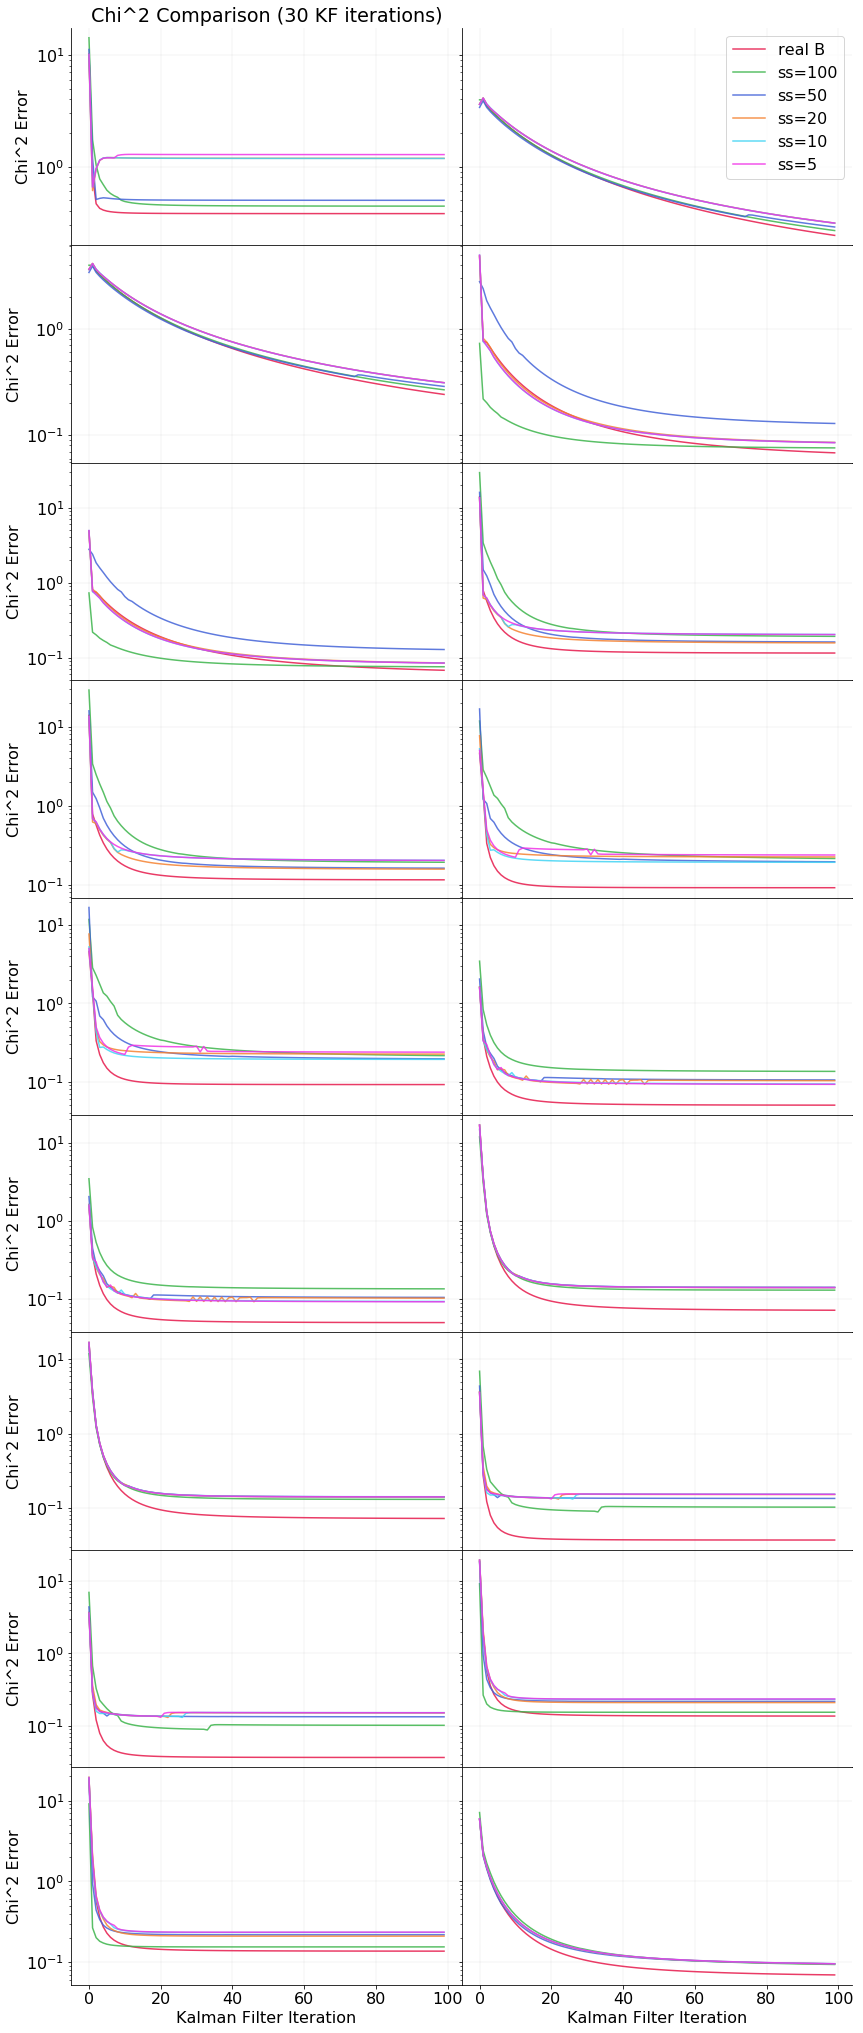

In [8]:
n_subplots = len(B_chi2[0])

ax = np.empty([int(n_subplots/2), 2])
f, ax = plt.subplots(int(n_subplots/2), 2, sharex="col", sharey="row")
f.set_size_inches((14,int(4*n_subplots/2)))

index = np.arange(len(B_chi2[0][0]))
for i in range(0, n_subplots, 2):
    for j in range(len(B_chi2)):
        ax[int(i/2),0].plot(   index, B_chi2[j][int(i/2)],   c=contrast_colors[j], alpha=baralpha, label=labels[j])
        ax[int(i/2),1].plot(   index, B_chi2[j][int(i/2)+1], c=contrast_colors[j], alpha=baralpha, label=labels[j])
    
    # SETTINGS
    for j in range(2):
        ax[int(i/2),j].spines['right'].set_visible(False)
        ax[int(i/2),j].grid(color=gray, linestyle='-', linewidth=0.25, alpha=0.5)
        ax[int(i/2),j].set_yscale("log")

ax[0,0].set_title("Chi^2 Comparison (30 KF iterations)")
ax[0,1].legend()

for i in range(int(n_subplots/2)):
    ax[i,0].set_ylabel("Chi^2 Error")
for j in range(2):
    ax[0,j].spines["top"].set_visible(False)
    ax[int(n_subplots/2 - 1), j].set_xlabel("Kalman Filter Iteration")

f.subplots_adjust(hspace=0, wspace=0)
plt.show()

# Final Chi^2 error difference

ValueError: x and y must be the same size

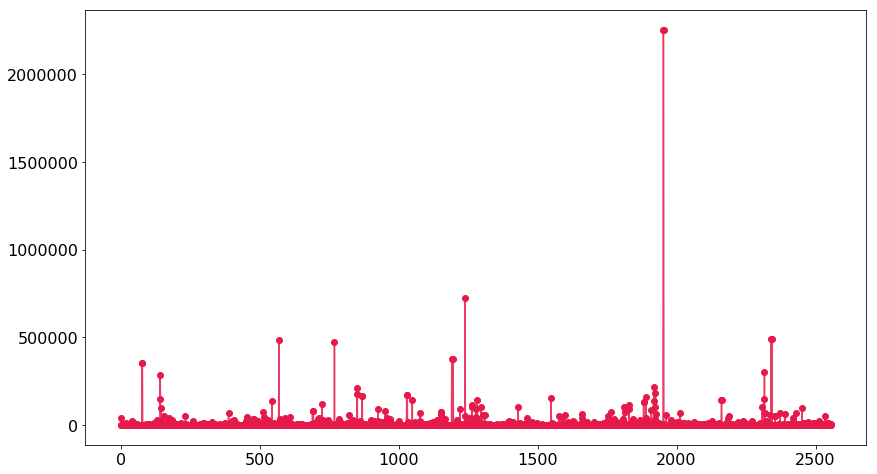

In [25]:
fig, ax = plt.subplots()

fig.set_size_inches(plot_size)
index = np.arange(len(B_fchi2[0]))

for i in range(len(B_fchi2)):
    ax.scatter(index, B_fchi2[i], c=contrast_colors[i], label=labels[i])
    ax.plot(   index, B_fchi2[i], c=contrast_colors[i], alpha=baralpha)

ax.spines['right'].set_visible(False)
ax.grid(color=gray, linestyle='-', linewidth=0.25, alpha=0.5)
ax.set_yscale("log")

plt.xlabel("Event")
plt.ylabel("Final Chi^2 Error")
plt.title("Final Chi^2 Error per Event (30 KF iterations)")
plt.xticks(index, filenames)
plt.legend()

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(color=gray, linestyle='-', linewidth=0.25, alpha=0.5)

plt.tight_layout()
plt.show()

In [8]:
def plot_b(b, density):
    x, y = np.meshgrid(b[0][0], b[0][1])
    bx = []
    by = []
    f, axes = plt.subplots(nrows=2, ncols=2, sharex="col", sharey="row", figsize=plot_size)
    
    for i in range(4):
        bx.append(np.array(pack_data(b[i][2], len(b[i][1]))))
        by.append(np.array(pack_data(b[i][3], len(b[i][1]))))
        axes[int(i/2), i%2].streamplot(x, y, bx[i], by[i], density=density, color=contrast_colors[i])
    
    plt.tight_layout()
    f.subplots_adjust(hspace=0, wspace=0)
    plt.show()

In [9]:
z = widgets.IntSlider(min=200, max=600, step=10)
display(z)

IntSlider(value=200, max=600, min=200, step=10)

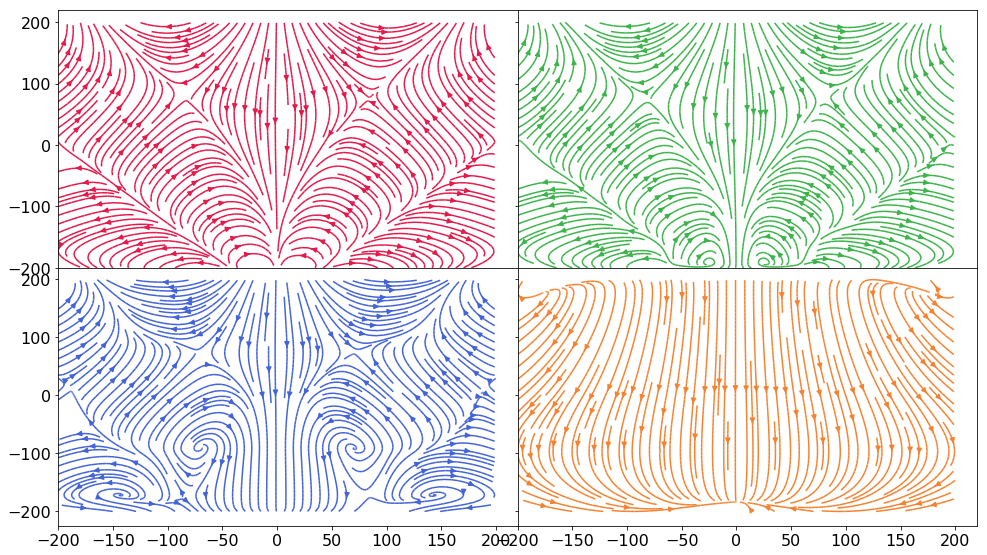

In [13]:
plot_b([B_meas[0][z.value], B_meas[1][z.value], B_meas[2][z.value], B_meas[3][z.value]], 2)

In [77]:
mdir        = "bfield_tests/"
dirs        = ["real_B/", "sim_B200/", "sim_B100/", "sim_B050/", "sim_B020/", "sim_B010/", "sim_B005/"]

B_fchi2     = []

for dir in dirs:
    B_fchi2.append(file_to_arr(mdir + dir + "finalchi2_e1000"))

B_fchi2_clean = []
for arr in B_fchi2:
    B_fchi2_clean.append(remove_outliers(arr, 3))

B_fchi2_avg = []
for arr in B_fchi2_clean:
    B_fchi2_avg.append(np.average(arr))

for i in range(len(B_fchi2_avg)-1,-1,-1):
    B_fchi2_avg[i] = B_fchi2_avg[i]/B_fchi2_avg[0]

# Chi^2 Error Distribution

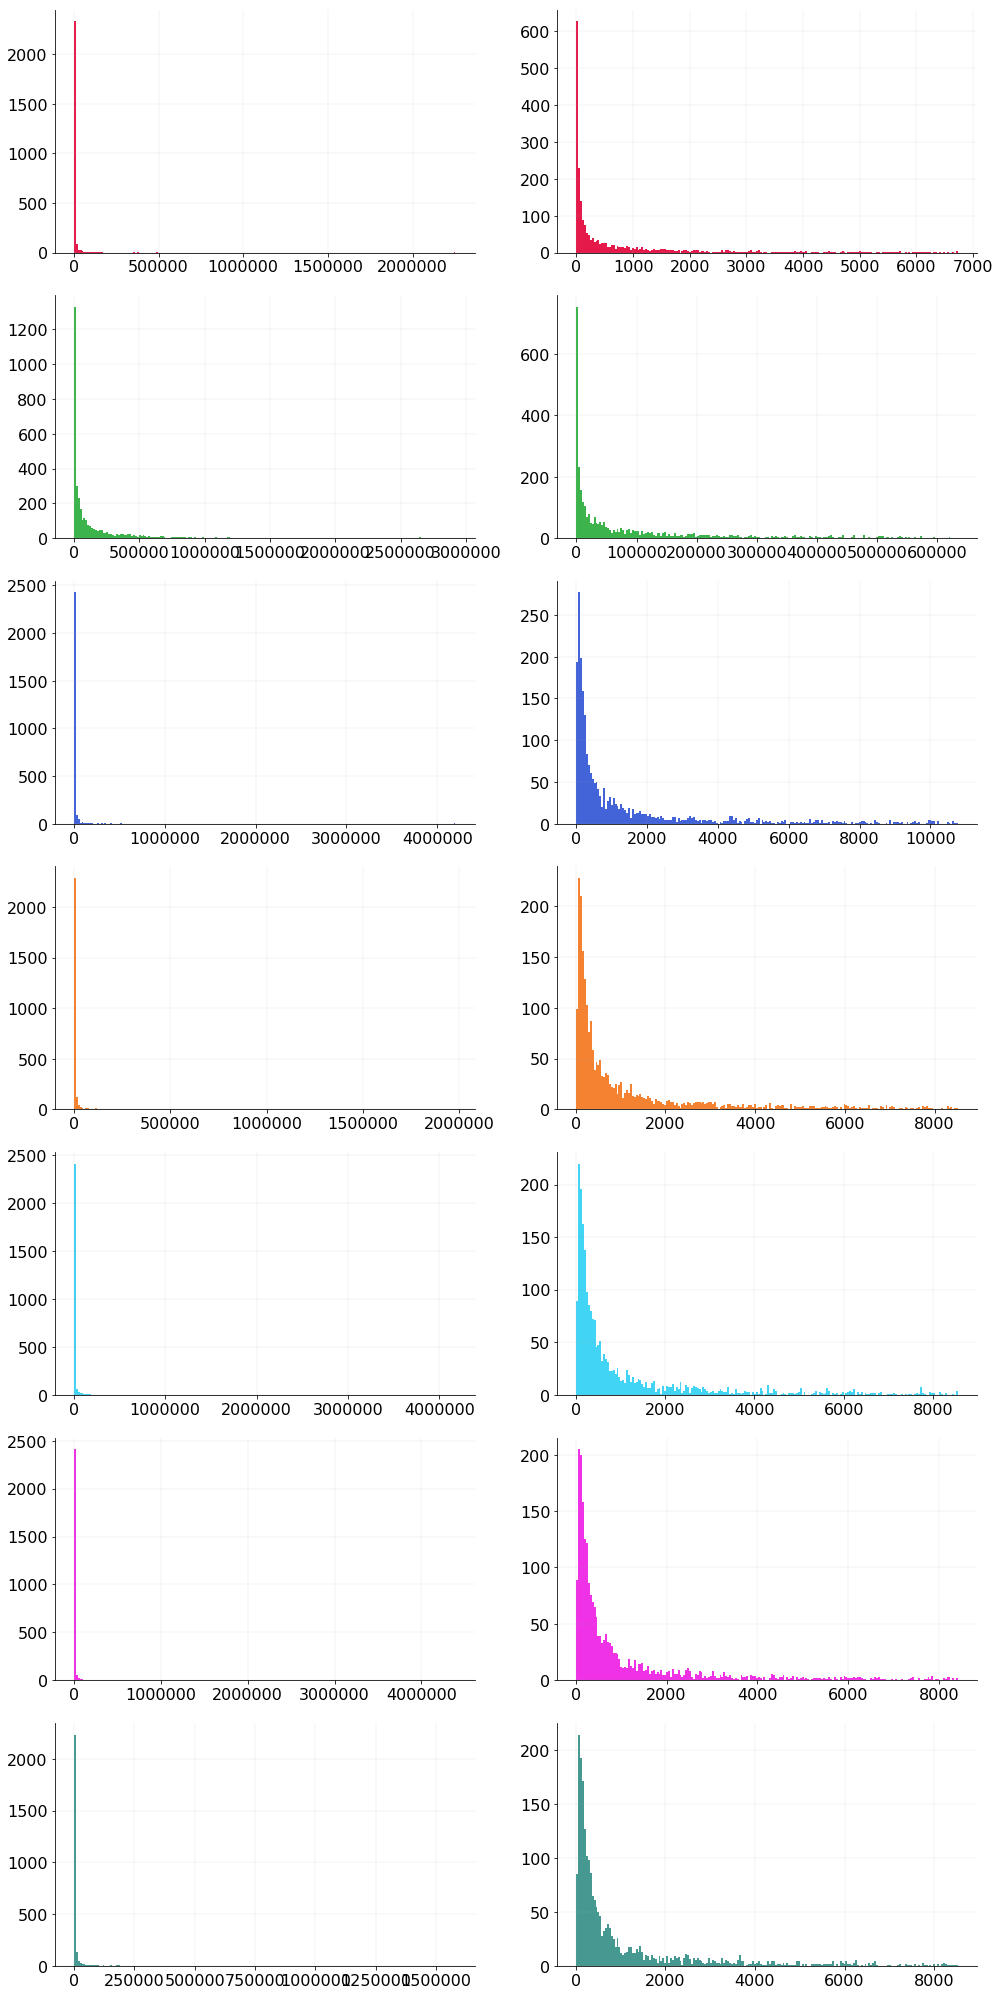

In [74]:
f, axes = plt.subplots(nrows=len(B_fchi2), ncols=2)
f.set_size_inches((14,int(4*len(B_fchi2))))

for i in range(len(B_fchi2)):
    axes[i, 0].hist(B_fchi2[i],       bins = 200, color=contrast_colors[i])
    axes[i, 1].hist(B_fchi2_clean[i], bins = 200, color=contrast_colors[i])

for i in range(len(axes)):
    for j in range(len(axes[i])):
        axes[i,j].spines['top'].set_visible(False)
        axes[i,j].spines['right'].set_visible(False)
        axes[i,j].grid(color=gray, linestyle='-', linewidth=0.25, alpha=0.5)

plt.tight_layout()

plt.show()

# Interpolation Accuracy vs Time

In [105]:
colors         = ["#000000", "#6e001a", "#e6194b", "#ff7f9d", "#7e3500", "#f58231", "#ffc091", "#00680c", 
                  "#3cb44b", "#86f093", "#006e86", "#42d4f4", "#99edff", "#001a7c", "#4363d8", "#8da5ff", 
                  "#46005a", "#911eb4", "#dd67ff"]
names          = ["realB",          "simB_ss200r400", "simB_ss200r200", "simB_ss200r100", 
                  "simB_ss100r400", "simB_ss100r200", "simB_ss100r100", "simB_ss050r400", 
                  "simB_ss050r200", "simB_ss050r100", "simB_ss020r400", "simB_ss020r200", 
                  "simB_ss020r100", "simB_ss010r400", "simB_ss010r200", "simB_ss010r100",
                  "simB_ss005r400", "simB_ss005r200", "simB_ss005r100"]
avg_fchi2      = [1.,                 122.59054174746021, 122.59054174746021, 122.59054174746021, 
                  1.7330013222060718, 1.7330013222060718, 1.7330013222060718, 1.4190169657940002, 
                  1.4190169657940002, 1.4190169657940002, 1.4136513546121674, 1.4136513546121674,
                  1.4136513546121674, 1.3822203302209861, 1.3822203302209861, 1.3822203302209861,
                  1.3829756488152811, 1.3829756488152811, 1.3829756488152811]
total_time     = [113.63, 123.74, 110.53, 106.63, 108.56,  98.61,  96.31, 106.13, 107.14, 105.30, 
                  102.24, 106.97, 107.85,  96.78,  96.30, 105.28,1048.30, 105.20, 101.79]
tracks_dropped = [126,  2,  0, 88, 26, 27, 66, 99, 98,127, 71, 68, 79, 63, 70, 75, 80, 71, 90]

In [106]:
def scatter_plot(ttime, fchi2, colors, labels):
    fig, ax = plt.subplots()
    fig.set_size_inches((14,9))

    for i in range(len(names)):
        ax.scatter(ttime[i], fchi2[i], c=colors[i], label=labels[i])
    plt.xscale('log')
    plt.xlabel("total time")
    plt.yscale('log')
    plt.ylabel("avg. chi^2 error / real chi^2 error")
    plt.legend()
    plt.show()
    
    return

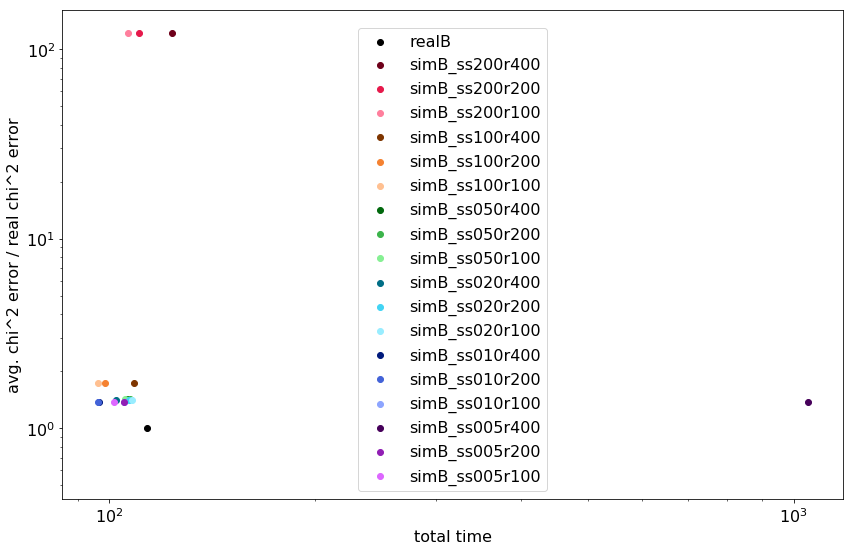

In [107]:
scatter_plot(total_time, avg_fchi2, colors, names)

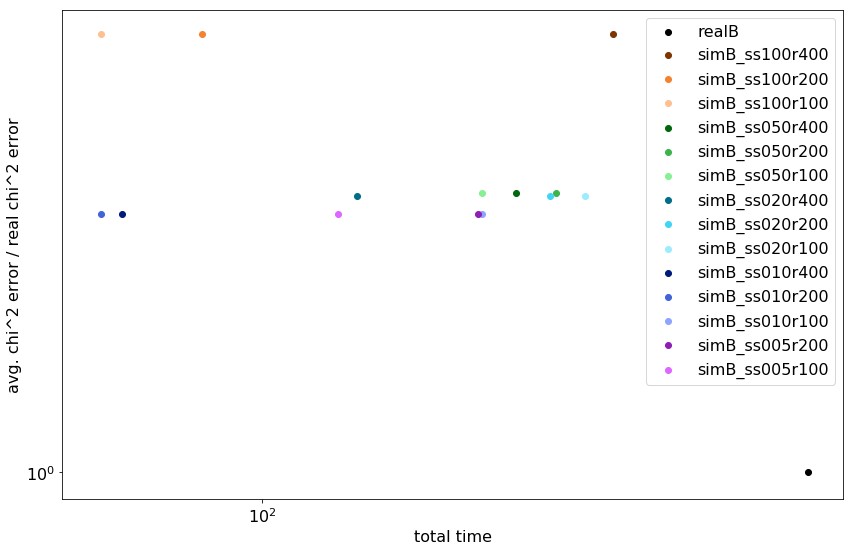

In [108]:
remove = [16, 3, 2, 1]
for i in remove:
    colors.pop(i)
    names.pop(i)
    avg_fchi2.pop(i)
    total_time.pop(i)
    tracks_dropped.pop(i)

scatter_plot(total_time, avg_fchi2, colors, names)